# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import pyspark.sql.functions as fn

import seaborn as sns
import numpy as np
import pandas as pd

import datetime
import time
import matplotlib.pyplot as plt




In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("fengzhenrong Spark Project") \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
#df.persist()

In [4]:
# 查看数据集结构
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [6]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [7]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
#查看每行记录的缺失值
df.rdd.map(lambda row:(row['userId'],sum([c==None for c in row]))).collect()

[('30', 0),
 ('9', 0),
 ('30', 0),
 ('9', 0),
 ('30', 0),
 ('9', 0),
 ('9', 0),
 ('30', 0),
 ('30', 3),
 ('30', 0),
 ('9', 0),
 ('9', 3),
 ('30', 0),
 ('9', 0),
 ('9', 3),
 ('30', 0),
 ('9', 0),
 ('74', 0),
 ('30', 0),
 ('9', 0),
 ('74', 0),
 ('30', 0),
 ('54', 0),
 ('9', 0),
 ('74', 0),
 ('30', 0),
 ('54', 0),
 ('9', 0),
 ('74', 0),
 ('30', 0),
 ('54', 0),
 ('9', 0),
 ('30', 0),
 ('74', 0),
 ('54', 0),
 ('54', 3),
 ('30', 0),
 ('9', 0),
 ('30', 0),
 ('54', 0),
 ('74', 0),
 ('9', 0),
 ('74', 0),
 ('54', 0),
 ('54', 3),
 ('30', 0),
 ('9', 0),
 ('9', 3),
 ('74', 0),
 ('30', 0),
 ('9', 0),
 ('9', 3),
 ('9', 0),
 ('9', 3),
 ('74', 0),
 ('30', 0),
 ('74', 3),
 ('', 9),
 ('', 9),
 ('', 9),
 ('', 9),
 ('9', 3),
 ('9', 0),
 ('30', 0),
 ('74', 0),
 ('9', 0),
 ('74', 0),
 ('9', 0),
 ('30', 0),
 ('74', 0),
 ('30', 0),
 ('30', 3),
 ('74', 0),
 ('9', 0),
 ('4', 0),
 ('4', 3),
 ('', 9),
 ('', 9),
 ('4', 3),
 ('30', 0),
 ('74', 0),
 ('74', 3),
 ('74', 0),
 ('4', 0),
 ('30', 0),
 ('9', 0),
 ('4', 3),


In [9]:
# 可以看出，userid，有值为空‘’的数据，我们的主要是探索用户流失情况，userid为空的需要刷选出来
# 先查用户总数
df.count()

286500

In [11]:
# 查找用户为空的有多少条记录
df.filter(df.userId == "").count()

8346

In [10]:
# 把用户不为空的刷选出来
df_clean = df.filter(df.userId != "")

In [11]:
df_clean.count()

278154

In [14]:
df_clean.where('userId == 9').show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|   NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|              Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...

In [15]:
# 查看歌曲为空的用户交互数据
df_clean.select('userID', 'page', 'ts').where("song is null and userId == 9").show()


+------+---------------+-------------+
|userID|           page|           ts|
+------+---------------+-------------+
|     9|    Roll Advert|1538353150000|
|     9|      Thumbs Up|1538353376000|
|     9|    Thumbs Down|1538355306000|
|     9|           Home|1538355504000|
|     9|         Logout|1538355687000|
|     9|           Home|1538355855000|
|     9|      Thumbs Up|1538357160000|
|     9|    Roll Advert|1538358779000|
|     9|Add to Playlist|1538359261000|
|     9|        Upgrade|1538360042000|
|     9|        Upgrade|1538360044000|
|     9|    Roll Advert|1538360228000|
|     9|           Home|1538484594000|
|     9|Add to Playlist|1538484619000|
|     9|      Thumbs Up|1538484629000|
|     9|Add to Playlist|1538484629000|
|     9|    Roll Advert|1538485211000|
|     9|    Roll Advert|1538485372000|
|     9|      Thumbs Up|1538485489000|
|     9|    Roll Advert|1538485750000|
+------+---------------+-------------+
only showing top 20 rows



In [16]:
# 查看歌曲为空的用户的page数据
df_clean.select("page").where("song is null").groupBy("page").count().collect()

[Row(page='Cancel', count=52),
 Row(page='Submit Downgrade', count=63),
 Row(page='Thumbs Down', count=2546),
 Row(page='Home', count=10082),
 Row(page='Downgrade', count=2055),
 Row(page='Roll Advert', count=3933),
 Row(page='Logout', count=3226),
 Row(page='Save Settings', count=310),
 Row(page='Cancellation Confirmation', count=52),
 Row(page='About', count=495),
 Row(page='Settings', count=1514),
 Row(page='Add to Playlist', count=6526),
 Row(page='Add Friend', count=4277),
 Row(page='Thumbs Up', count=12551),
 Row(page='Help', count=1454),
 Row(page='Upgrade', count=499),
 Row(page='Error', count=252),
 Row(page='Submit Upgrade', count=159)]

In [17]:
# 从结果来看，歌曲为空的情况下，用户交互数据比较多，而且我们也需要这些交互数据来进行预测客户流失情况，所以歌曲song为空的数据不需要清理

In [18]:
#统计每列数据缺失情况
df_clean.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c)
    for c in df_clean.columns
]).show()

+-------------------+----+---------+------+-------------+--------+-------------------+-----+--------+------+----+------------+---------+-------------------+------+---+---------+------+
|             artist|auth|firstName|gender|itemInSession|lastName|             length|level|location|method|page|registration|sessionId|               song|status| ts|userAgent|userId|
+-------------------+----+---------+------+-------------+--------+-------------------+-----+--------+------+----+------------+---------+-------------------+------+---+---------+------+
|0.17992191376000344| 0.0|      0.0|   0.0|          0.0|     0.0|0.17992191376000344|  0.0|     0.0|   0.0| 0.0|         0.0|      0.0|0.17992191376000344|   0.0|0.0|      0.0|   0.0|
+-------------------+----+---------+------+-------------+--------+-------------------+-----+--------+------+----+------------+---------+-------------------+------+---+---------+------+



In [19]:
# 看出字段artist，length，song，缺失比例都一样，都是歌曲song为空的数据情况下，不需要清理

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [20]:

end_time = 1538353150000
d = datetime.datetime.fromtimestamp(end_time / 1000, None)  # 时间戳转换成字符串日期时间
str1 = d.strftime("%Y-%m-%d %H:%M:%S.%f")
print(d)
print(str1)


2018-10-01 08:19:10
2018-10-01 08:19:10.000000


In [21]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [22]:
dt = datetime.time()  
print ("datetime:",dt.strftime("%Y-%m-%d %H:%M:%S"))
print (dt.strftime("%H"))

datetime: 1900-01-01 00:00:00
00


In [12]:
# 时间戳查看起来比较困难，我们把时间戳转成年月日时间
clean_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn("datetime", clean_time(df_clean.ts))


In [13]:
df_clean.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)



In [25]:
df_clean.describe().show()

+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+-------------------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|           userId|           datetime|
+-------+------------------+---------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+-----------------+-------------------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|           

In [26]:
# 查看page事件有那些
df_clean.select("page").groupby("page").count().sort("count", ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [27]:
# 查看level有那些
df_clean.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [16]:
# 查看用户执行Cancellation Confirmation操作的用户有那些
df_churn_users = df_clean.select("userId", "page", "level", "datetime").where("page='Cancellation Confirmation'").dropDuplicates().sort("datetime", ascending=False)
df_churn_users.show()


+------+--------------------+-----+-------------------+
|userId|                page|level|           datetime|
+------+--------------------+-----+-------------------+
|100007|Cancellation Conf...| paid|2018-11-29 19:45:09|
|100021|Cancellation Conf...| free|2018-11-25 19:03:02|
|100015|Cancellation Conf...| paid|2018-11-24 23:35:53|
|300001|Cancellation Conf...| paid|2018-11-24 05:42:24|
|100014|Cancellation Conf...| paid|2018-11-21 03:04:09|
|    53|Cancellation Conf...| paid|2018-11-19 20:34:56|
|200020|Cancellation Conf...| free|2018-11-18 00:40:42|
|200016|Cancellation Conf...| free|2018-11-16 16:17:58|
|200017|Cancellation Conf...| paid|2018-11-16 04:16:43|
|    70|Cancellation Conf...| paid|2018-11-15 06:34:27|
|    29|Cancellation Conf...| paid|2018-11-14 15:37:11|
|    54|Cancellation Conf...| paid|2018-11-13 03:40:08|
|100022|Cancellation Conf...| free|2018-11-13 00:04:05|
|200015|Cancellation Conf...| free|2018-11-09 15:01:03|
|    28|Cancellation Conf...| paid|2018-11-06 08

In [29]:
# 查看用户为100007执行什么操作，NextSong操作太多，先去掉
df_clean.select("userId", "page", "level", "datetime").where("userId='100007' and page!='NextSong'").sort("datetime", ascending=False).show()


+------+--------------------+-----+-------------------+
|userId|                page|level|           datetime|
+------+--------------------+-----+-------------------+
|100007|Cancellation Conf...| paid|2018-11-29 19:45:09|
|100007|              Cancel| paid|2018-11-29 19:45:07|
|100007|           Downgrade| paid|2018-11-29 19:45:06|
|100007|         Thumbs Down| paid|2018-11-29 19:39:42|
|100007|           Thumbs Up| paid|2018-11-29 19:32:25|
|100007|           Downgrade| paid|2018-11-29 18:11:50|
|100007|           Thumbs Up| paid|2018-11-29 17:14:06|
|100007|                Help| paid|2018-11-29 16:56:11|
|100007|         Roll Advert| paid|2018-11-29 16:23:26|
|100007|           Thumbs Up| paid|2018-11-29 16:06:59|
|100007|           Thumbs Up| paid|2018-11-29 15:49:27|
|100007|                Home| paid|2018-11-29 14:44:29|
|100007|              Logout| paid|2018-11-29 14:43:38|
|100007|            Settings| paid|2018-11-29 14:33:52|
|100007|                Home| paid|2018-11-29 14

In [30]:
# 查看用户为200020执行什么操作，NextSong操作太多，先去掉
df_clean.select("userId", "page", "level", "datetime").where("userId='200020' and page!='NextSong'").sort("datetime", ascending=False).show()


+------+--------------------+-----+-------------------+
|userId|                page|level|           datetime|
+------+--------------------+-----+-------------------+
|200020|Cancellation Conf...| free|2018-11-18 00:40:42|
|200020|              Cancel| free|2018-11-18 00:40:30|
|200020|         Roll Advert| free|2018-11-18 00:40:29|
|200020|           Thumbs Up| free|2018-11-18 00:25:56|
|200020|           Thumbs Up| free|2018-11-18 00:22:40|
|200020|                Home| free|2018-11-18 00:18:09|
|200020|         Roll Advert| free|2018-11-18 00:07:15|
|200020|           Thumbs Up| free|2018-11-17 23:57:00|
|200020|            Settings| free|2018-11-17 23:53:01|
|200020|          Add Friend| free|2018-11-17 23:52:55|
|200020|     Add to Playlist| free|2018-11-17 23:52:05|
|200020|         Roll Advert| free|2018-11-17 23:43:15|
|200020|         Roll Advert| free|2018-11-17 23:29:11|
|200020|         Thumbs Down| free|2018-11-17 23:22:05|
|200020|     Add to Playlist| free|2018-11-17 23

In [31]:
df_clean.select("userId").where("page='Cancellation Confirmation'").dropDuplicates().show()


+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
+------+
only showing top 20 rows



In [32]:
df_churn_users.count()

52

In [14]:
# 转化小时hour
clean_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
df_clean = df_clean.withColumn("hour", clean_hour(df_clean.ts))


In [17]:
# 根据Cancellation Confirmation重新定义一个Churn用来区分用户
df_churn_users_event = [(row["userId"]) for row in df_churn_users.collect()]

df_clean = df_clean.withColumn("CancelStatus", df_clean.userId.isin(df_churn_users_event))

flag_CancelStatus_event = udf(lambda x: 1 if x else 0, IntegerType())
df_clean = df_clean.withColumn("churn", flag_CancelStatus_event("CancelStatus"))


In [18]:
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday(), IntegerType())
df_clean = df_clean.withColumn("weekday", get_weekday(df_clean.ts))

get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month, IntegerType())
df_clean = df_clean.withColumn("month", get_month(df_clean.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day, IntegerType())
df_clean = df_clean.withColumn("day", get_day(df_clean.ts))

In [19]:
# 根据Submit Downgrade重新定义一个downgraded用来区分降级用户
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("downgraded", flag_downgrade_event("page"))

In [20]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- CancelStatus: boolean (nullable = true)
 |-- churn: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- downgraded: integer (nullab

In [38]:
df_clean.select("userId", "page", "level", "datetime", "month", "weekday", "day", "hour").where("userId='200020'").sort("datetime", ascending=False).show()


+------+--------------------+-----+-------------------+-----+-------+---+----+
|userId|                page|level|           datetime|month|weekday|day|hour|
+------+--------------------+-----+-------------------+-----+-------+---+----+
|200020|Cancellation Conf...| free|2018-11-18 00:40:42|   11|      6| 18|   0|
|200020|              Cancel| free|2018-11-18 00:40:30|   11|      6| 18|   0|
|200020|         Roll Advert| free|2018-11-18 00:40:29|   11|      6| 18|   0|
|200020|            NextSong| free|2018-11-18 00:39:55|   11|      6| 18|   0|
|200020|            NextSong| free|2018-11-18 00:33:53|   11|      6| 18|   0|
|200020|            NextSong| free|2018-11-18 00:30:22|   11|      6| 18|   0|
|200020|           Thumbs Up| free|2018-11-18 00:25:56|   11|      6| 18|   0|
|200020|            NextSong| free|2018-11-18 00:25:55|   11|      6| 18|   0|
|200020|           Thumbs Up| free|2018-11-18 00:22:40|   11|      6| 18|   0|
|200020|            NextSong| free|2018-11-18 00:22:

In [39]:
# 流失用户churn的集合
df_churn = df_clean.where("churn=1")
# 留存用户no-churn的集合
df_nochurn = df_clean.where("churn=0")

In [40]:
print("churn_count:",df_churn.count(),"no-churn_count:",df_nochurn.count())

churn_count: 44864 no-churn_count: 233290


In [41]:
# 查看churn状态和非churn状态的用户page事件
df_churn_page = df_clean.select("churn", "page").where("page!='Cancellation Confirmation' and page!='Cancel'").groupby("churn", "page").count().sort(["page", "churn", "count"], ascending=False)
df_churn_page.show(50)


+-----+----------------+------+
|churn|            page| count|
+-----+----------------+------+
|    1|         Upgrade|   112|
|    0|         Upgrade|   387|
|    1|       Thumbs Up|  1859|
|    0|       Thumbs Up| 10692|
|    1|     Thumbs Down|   496|
|    0|     Thumbs Down|  2050|
|    1|  Submit Upgrade|    32|
|    0|  Submit Upgrade|   127|
|    1|Submit Downgrade|     9|
|    0|Submit Downgrade|    54|
|    1|        Settings|   270|
|    0|        Settings|  1244|
|    1|   Save Settings|    58|
|    0|   Save Settings|   252|
|    1|     Roll Advert|   967|
|    0|     Roll Advert|  2966|
|    1|        NextSong| 36394|
|    0|        NextSong|191714|
|    1|          Logout|   553|
|    0|          Logout|  2673|
|    1|            Home|  1672|
|    0|            Home|  8410|
|    1|            Help|   239|
|    0|            Help|  1215|
|    1|           Error|    32|
|    0|           Error|   220|
|    1|       Downgrade|   337|
|    0|       Downgrade|  1718|
|    1| 

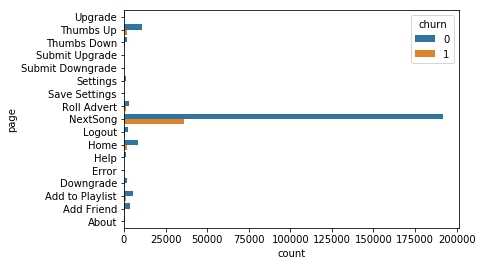

In [42]:
# 查看churn状态和非churn状态的用户page事件
sns.barplot(x='count', y='page', hue='churn', data=df_churn_page.toPandas())

In [43]:
# 可以看出用户听歌操作比较多，这样看起来比较大，查看除了nextsong其他page的信息
df_churn_page_nosong=df_clean.select("churn", "page").where("page!='NextSong' and page!='Cancel'").groupby("churn", "page").count().sort(["page", "churn", "count"], ascending=False)
df_churn_page_nosong.show(50)


+-----+--------------------+-----+
|churn|                page|count|
+-----+--------------------+-----+
|    1|             Upgrade|  112|
|    0|             Upgrade|  387|
|    1|           Thumbs Up| 1859|
|    0|           Thumbs Up|10692|
|    1|         Thumbs Down|  496|
|    0|         Thumbs Down| 2050|
|    1|      Submit Upgrade|   32|
|    0|      Submit Upgrade|  127|
|    1|    Submit Downgrade|    9|
|    0|    Submit Downgrade|   54|
|    1|            Settings|  270|
|    0|            Settings| 1244|
|    1|       Save Settings|   58|
|    0|       Save Settings|  252|
|    1|         Roll Advert|  967|
|    0|         Roll Advert| 2966|
|    1|              Logout|  553|
|    0|              Logout| 2673|
|    1|                Home| 1672|
|    0|                Home| 8410|
|    1|                Help|  239|
|    0|                Help| 1215|
|    1|               Error|   32|
|    0|               Error|  220|
|    1|           Downgrade|  337|
|    0|           Do

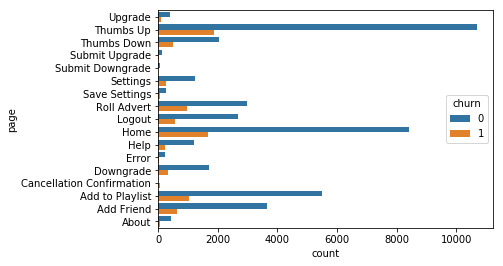

In [44]:
sns.barplot(x='count', y='page', hue='churn', data=df_churn_page_nosong.toPandas())

In [60]:
# 统计churn==0的page数量
df_nochurn_pagecount=df_clean.select("churn", "page").where("churn = 0 ").groupby("churn", "page").count().sort(["count"], ascending=False)
df_nochurn_pagecount = df_nochurn_pagecount.withColumn("nochurn", df_nochurn_pagecount["churn"])
df_nochurn_pagecount = df_nochurn_pagecount.withColumn("nochurncount", df_nochurn_pagecount["count"])
df_nochurn_pagecount = df_nochurn_pagecount.drop("churn", "count")
# 统计churn==1的page数量
df_churn_pagecount=df_clean.select("churn", "page").where("churn = 1 ").groupby("churn", "page").count().sort(["page", "churn", "count"], ascending=False)
df_churn_pagecount = df_churn_pagecount.withColumn("churncount", df_churn_pagecount["count"])
df_churn_pagecount = df_churn_pagecount.drop("count")
# 把nochurn跟churn的表集合一起，使用leftjoin
df_nosong_pagecount = df_nochurn_pagecount.join(df_churn_pagecount, "page", "left")
# 统计nochurn表跟churn表中的数量比例;churncount/ (churncount+nochurncount)
df_nosong_pagecount = df_nosong_pagecount.withColumn("countrate", df_nosong_pagecount["churncount"] / (df_nosong_pagecount["churncount"] + df_nosong_pagecount["nochurncount"] )).sort("countrate", ascending=True)


In [61]:
df_nosong_pagecount.show(50)

+----------------+-------+------------+-----+----------+-------------------+
|            page|nochurn|nochurncount|churn|churncount|          countrate|
+----------------+-------+------------+-----+----------+-------------------+
|           About|      0|         439|    1|        56|0.11313131313131314|
|           Error|      0|         220|    1|        32|0.12698412698412698|
|Submit Downgrade|      0|          54|    1|         9|0.14285714285714285|
|       Thumbs Up|      0|       10692|    1|      1859| 0.1481156879929886|
|      Add Friend|      0|        3641|    1|       636|0.14870236146831892|
| Add to Playlist|      0|        5488|    1|      1038| 0.1590560833588722|
|        NextSong|      0|      191714|    1|     36394|0.15954723201290616|
|       Downgrade|      0|        1718|    1|       337|0.16399026763990268|
|            Help|      0|        1215|    1|       239| 0.1643741403026135|
|            Home|      0|        8410|    1|      1672|0.16584011108906963|

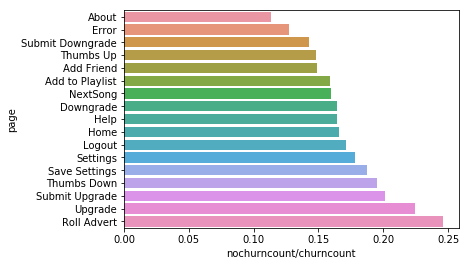

In [62]:
ax = sns.barplot(x='countrate', y='page', data=df_nosong_pagecount.toPandas())
ax.set(xlabel='nochurncount/churncount', ylabel='page')
plt.show()

In [ ]:
# countrate的值越小，证明churn/nochurn的发差越大，about这个感觉没什么用， 我认为可以考虑error,Submit Downgrade,Thumbs Up，Add Friend， Add to Playlist，NextSong，Downgrade等字段次数特征；


In [75]:
# 查看用户在那天听歌的时长
df_pd = df_clean.filter("page='NextSong'").groupby("churn", "day").sum("length").withColumnRenamed("sum(length)", "count").orderBy(df_clean["day"].cast("float")).toPandas()
df_pd["day"] = pd.to_numeric(df_pd["day"])


In [76]:
df_pd.head(5)

,churn,day,count
0,1,1,2.949764e+05
1,0,1,1.771679e+06
2,1,2,5.039052e+05
3,0,2,1.999378e+06
4,1,3,4.894362e+05


In [79]:
# 可以看出执行听歌nextsong的多
# 查看用户在什么时间段听歌的时长，定义一个方法查看,"month", "weekday", "day", "hour"
def plot_songcount_by_churn(time, kind="line"): 
    df_pd = df_clean.filter("page='NextSong'").groupby("churn", time).sum("length").withColumnRenamed("sum(length)", "count").orderBy(df_clean[time].cast("float")).toPandas()
    df_nochurn_pd = df_pd[df_pd["churn"]==0]
    df_churn_pd = df_pd[df_pd["churn"]==1]
    
    df_nochurn_pd.plot(x=time, y='count', color='Green', label='Not churn',kind=kind)
    df_churn_pd.plot(x=time, y='count', color='Red', label='Churn',kind=kind)

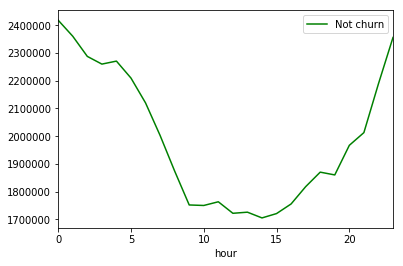

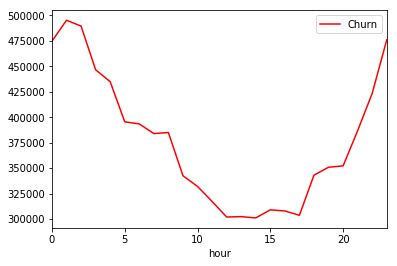

In [80]:
# 查看小时时间段听歌nextsong的时长和
plot_songcount_by_churn("hour")


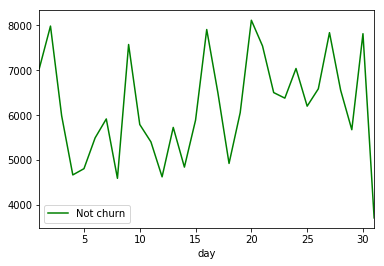

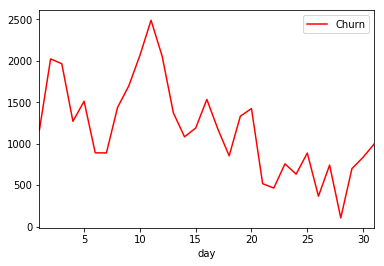

In [86]:
# 查看天数时间段听歌nextsong的时长和
plot_songcount_by_churn("day")

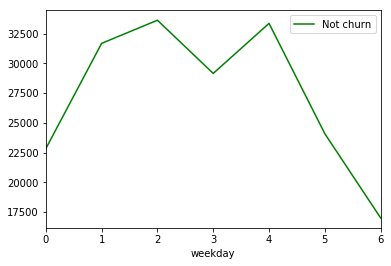

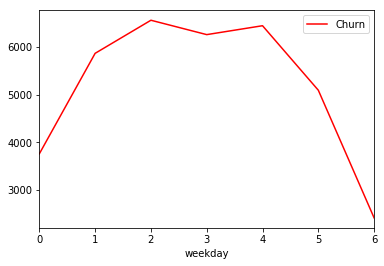

In [100]:
# 查看周时间段听歌nextsong的时长和
plot_songcount_by_churn("weekday")

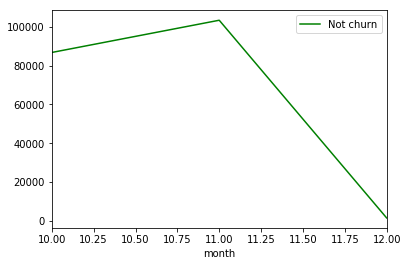

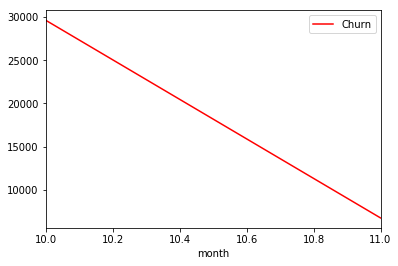

In [101]:
# 查看月时间段听歌nextsong的时长和
plot_songcount_by_churn("month")

In [ ]:
# 从时间段来看用户在白天听歌比较小，在晚上听歌较多，还有用户在周二到周五听歌多点，听歌时长也可以作为一个特征分析

In [116]:
# 查看churn跟gender的关系
df_churn_gender = df_clean.dropDuplicates(["userId", "gender"]).groupby("churn", "gender").count().sort("count", ascending=False)
df_churn_gender.show()


+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
+-----+------+-----+



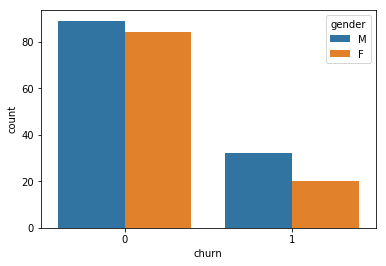

In [117]:
# 通过图表查看churn跟gender的关系
sns.barplot(x='churn', y='count', hue='gender', data=df_churn_gender.toPandas())

In [112]:
# 查看churn跟level的关系
df_churn_level = df_clean.dropDuplicates(["userId", "level"]).groupby("churn", "level").count().sort("count", ascending=False)
df_churn_level.show()


+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|false| free|  149|
|false| paid|  129|
| true| free|   46|
| true| paid|   36|
+-----+-----+-----+



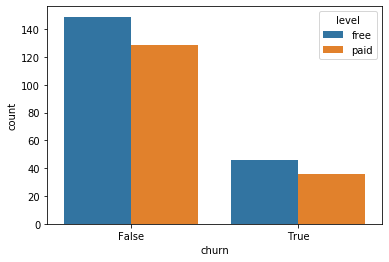

In [114]:
# 通过图表查看churn跟level的关系
sns.barplot(x='churn', y='count', hue='level', data=df_churn_level.toPandas())

In [120]:
df_clean_pd = df_clean.select("userId", "churn", "level", "gender").dropDuplicates().toPandas()

In [127]:
df_clean_pd[['churn', 'level', 'gender']].head()

,churn,level,gender
0,False,paid,F
1,False,free,F
2,True,paid,F
3,False,paid,F
4,True,paid,M


# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

 从上面分析来，我认为比较重要的特征有以下几个：
 
 - gender:性别
 - level:等级
 - song_time:听歌时长
 - error_count:error数量
 - Submit Downgrade_count:Submit Downgrade数量
 - ThumbsUp_count:Thumbs Up数量
 - AddFriend_count:Add Friend数量
 - AddPlaylist_count:Add to Playlist数量
 - Song_count:NextSong数量
 - Downgrade_count：Downgrade数量
 

In [21]:
# 定义一个临时数据库表
df_clean.createOrReplaceTempView("df_user_table")


In [22]:
df_features_clean = spark.sql('''
          SELECT DISTINCT 
          userId,  
          churn as label,
          (case when gender = 'F' then 0 else 1 end) as gender,
          (case when level = 'free' then 0 else 1 end) as level,
          COUNT(distinct song) as song_count,
          SUM(length) song_time,
          SUM(case when page = 'Error' then 1 else 0 end) as error_count,
          SUM(case when page = 'Submit Downgrade' then 1 else 0 end) as submit_downgrade_count,
          SUM(case when page = 'Thumbs Up' then 1 else 0 end) as thumbs_up_count,
          SUM(case when page = 'Add Friend' then 1 else 0 end) as add_friend_count,
          SUM(case when page = 'Add to Playlist' then 1 else 0 end) as add_playlist_count,
          SUM(case when page = 'Downgrade' then 1 else 0 end) as downgrade_count
          FROM df_user_table
          GROUP BY userId,churn,gender,level
          ''')

df_features = df_features_clean.toPandas()

In [23]:
df_features.head(10)

,userId,label,gender,level,song_count,song_time,error_count,submit_downgrade_count,thumbs_up_count,add_friend_count,add_playlist_count,downgrade_count
0,12,1,0,1,498,1.291691e+05,0,1,29,8,13,5
1,300004,0,0,1,118,2.994591e+04,0,1,11,1,2,1
2,38,0,1,0,71,1.672753e+04,0,0,3,3,1,0
3,139,0,1,0,27,6.235364e+03,0,0,2,0,4,0
4,92,0,0,1,4055,1.275323e+06,3,1,245,92,162,68
5,100009,1,1,0,235,5.930587e+04,0,0,16,3,5,0
6,118,0,0,1,1884,5.342812e+05,1,0,113,48,51,27
7,77,0,0,0,74,1.895873e+04,0,0,2,0,1,0
8,61,0,1,0,514,1.386067e+05,0,0,31,13,14,0
9,87,1,1,1,134,3.418401e+04,0,0,1,0,1,1


In [24]:
df_features.describe()

,label,gender,level,song_count,song_time,error_count,submit_downgrade_count,thumbs_up_count,add_friend_count,add_playlist_count,downgrade_count
count,360.000000,360.000000,360.000000,360.000000,3.590000e+02,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.227778,0.533333,0.458333,570.733333,1.582886e+05,0.700000,0.175000,34.863889,11.880556,18.127778,5.708333
std,0.419982,0.499582,0.498954,724.360151,2.159922e+05,1.163033,0.483646,52.061789,16.219925,25.826188,10.272387
min,0.000000,0.000000,0.000000,0.000000,2.297204e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,108.750000,2.726210e+04,0.000000,0.000000,5.000000,2.000000,3.000000,0.000000
50%,0.000000,1.000000,0.000000,282.000000,7.268770e+04,0.000000,0.000000,14.500000,6.000000,8.000000,0.000000
75%,0.000000,1.000000,1.000000,751.750000,1.998271e+05,1.000000,0.000000,40.250000,15.250000,24.250000,8.250000
max,1.000000,1.000000,1.000000,5043.000000,1.638520e+06,7.000000,3.000000,418.000000,122.000000,205.000000,73.000000


In [208]:
print(df_features.shape)

(360, 12)


In [209]:
# 查看有没有空值
df_features.isna().sum()

userId                    0
label                     0
gender                    0
level                     0
song_count                0
song_time                 1
error_count               0
submit_downgrade_count    0
thumbs_up_count           0
add_friend_count          0
add_playlist_count        0
downgrade_count           0
dtype: int64

In [25]:
# 把空值替换为0
df_features_clean = df_features_clean.fillna(0,subset=['song_time'])
df_features = df_features_clean.toPandas()

print(df_features.isna().sum())

userId                    0
label                     0
gender                    0
level                     0
song_count                0
song_time                 0
error_count               0
submit_downgrade_count    0
thumbs_up_count           0
add_friend_count          0
add_playlist_count        0
downgrade_count           0
dtype: int64


# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

### 评价指标

在项目中我定义两个指标，Accuracy准确率跟F1 score；准确率，该指标的高低决定模型的好坏程度，但需要结合训练集和测试集来看，如果训练集准确率太高，但测试集准确率过低，那模型就会过拟合；如果训练集和测试集的accuracy都太低，则说明欠拟合。F1 score是对测试准确性的度量，模型精准率和召回率的一种加权平均，它的最大值是1，最小值是0；

ROC的全名叫做Receiver Operating Characteristic，其主要分析工具是一个画在二维平面上的曲线——ROC curve。平面的横坐标是false positive rate(FPR)，纵坐标是true positive rate(TPR);

AUC（Area Under roc Curve）是一种用来度量分类模型好坏的一个标准。这样的标准其实有很多，例如：大约10年前在machine learning文献中一统天下的标准：分类精度；在信息检索(IR)领域中常用的recall和precision;


为什么选择F1score指标，因为我们需更加精准的了解客户流失情况，避免留存用户流失，precision 就更加重要；在检测的时候，我们不希望查漏任何一用户，这时 recall（TPR） 就更重要。当两者都需要考虑时，F1-score 就是一种参考指标。

### 参考文献

[F1 score](https://en.wikipedia.org/wiki/F1_score)

[ROC 和 AUC](https://blog.csdn.net/otengyue/article/details/89426004)


In [26]:
df_features_models = df_features_clean.drop("userId")

In [27]:
df_features_models.head(10)

[Row(label=1, gender=0, level=1, song_count=498, song_time=129169.13569999998, error_count=0, submit_downgrade_count=1, thumbs_up_count=29, add_friend_count=8, add_playlist_count=13, downgrade_count=5),
 Row(label=0, gender=0, level=1, song_count=118, song_time=29945.909930000005, error_count=0, submit_downgrade_count=1, thumbs_up_count=11, add_friend_count=1, add_playlist_count=2, downgrade_count=1),
 Row(label=0, gender=1, level=0, song_count=71, song_time=16727.529800000004, error_count=0, submit_downgrade_count=0, thumbs_up_count=3, add_friend_count=3, add_playlist_count=1, downgrade_count=0),
 Row(label=0, gender=1, level=0, song_count=27, song_time=6235.364090000001, error_count=0, submit_downgrade_count=0, thumbs_up_count=2, add_friend_count=0, add_playlist_count=4, downgrade_count=0),
 Row(label=0, gender=0, level=1, song_count=4055, song_time=1275322.5661599992, error_count=3, submit_downgrade_count=1, thumbs_up_count=245, add_friend_count=92, add_playlist_count=162, downgrade

In [28]:
# 行数据专程拜访向量
input_cols = df_features_clean.columns[2:]

In [29]:
input_cols

['gender',
 'level',
 'song_count',
 'song_time',
 'error_count',
 'submit_downgrade_count',
 'thumbs_up_count',
 'add_friend_count',
 'add_playlist_count',
 'downgrade_count']

In [41]:
# 归一化向量
assembler = VectorAssembler(inputCols=input_cols, outputCol="NumFeatures")
df_features_transform_models = assembler.transform(df_features_models)

# MinMaxScaler作用同样是每一列，即每一维特征。将每一维特征线性地映射到指定的区间，通常是[0, 1]
# StandardScaler处理的对象是每一列，也就是每一维特征，将特征标准化为单位标准差或是0均值，或是0均值单位标准差。
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="features")
scalerModel = scaler.fit(df_features_transform_models)
df_features_transform_models = scalerModel.transform(df_features_transform_models)

In [31]:
df_features_models.head(5)

[Row(label=1, gender=0, level=1, song_count=498, song_time=129169.13569999998, error_count=0, submit_downgrade_count=1, thumbs_up_count=29, add_friend_count=8, add_playlist_count=13, downgrade_count=5),
 Row(label=0, gender=0, level=1, song_count=118, song_time=29945.909930000005, error_count=0, submit_downgrade_count=1, thumbs_up_count=11, add_friend_count=1, add_playlist_count=2, downgrade_count=1),
 Row(label=0, gender=1, level=0, song_count=71, song_time=16727.529800000004, error_count=0, submit_downgrade_count=0, thumbs_up_count=3, add_friend_count=3, add_playlist_count=1, downgrade_count=0),
 Row(label=0, gender=1, level=0, song_count=27, song_time=6235.364090000001, error_count=0, submit_downgrade_count=0, thumbs_up_count=2, add_friend_count=0, add_playlist_count=4, downgrade_count=0),
 Row(label=0, gender=0, level=1, song_count=4055, song_time=1275322.5661599992, error_count=3, submit_downgrade_count=1, thumbs_up_count=245, add_friend_count=92, add_playlist_count=162, downgrade

In [32]:
df_features_transform_models.head(5)

[Row(label=1, gender=0, level=1, song_count=498, song_time=129169.13569999998, error_count=0, submit_downgrade_count=1, thumbs_up_count=29, add_friend_count=8, add_playlist_count=13, downgrade_count=5, NumFeatures=DenseVector([0.0, 1.0, 498.0, 129169.1357, 0.0, 1.0, 29.0, 8.0, 13.0, 5.0]), features=DenseVector([0.0, 2.0042, 0.6875, 0.5984, 0.0, 2.0676, 0.557, 0.4932, 0.5034, 0.4867])),
 Row(label=0, gender=0, level=1, song_count=118, song_time=29945.909930000005, error_count=0, submit_downgrade_count=1, thumbs_up_count=11, add_friend_count=1, add_playlist_count=2, downgrade_count=1, NumFeatures=DenseVector([0.0, 1.0, 118.0, 29945.9099, 0.0, 1.0, 11.0, 1.0, 2.0, 1.0]), features=DenseVector([0.0, 2.0042, 0.1629, 0.1387, 0.0, 2.0676, 0.2113, 0.0617, 0.0774, 0.0973])),
 Row(label=0, gender=1, level=0, song_count=71, song_time=16727.529800000004, error_count=0, submit_downgrade_count=0, thumbs_up_count=3, add_friend_count=3, add_playlist_count=1, downgrade_count=0, NumFeatures=DenseVector([

In [42]:
# 定义训练集跟测试集,[0.9, 0.1] 或者 [0.8, 0.2]
train, test = df_features_models.randomSplit([0.8, 0.2], seed=45)
train_tf, test_tf = df_features_transform_models.randomSplit([0.9, 0.1], seed=45)

In [35]:
train.head(5)

[Row(label=1, gender=0, level=1, song_count=498, song_time=129169.13569999998, error_count=0, submit_downgrade_count=1, thumbs_up_count=29, add_friend_count=8, add_playlist_count=13, downgrade_count=5),
 Row(label=0, gender=0, level=1, song_count=1884, song_time=534281.17723, error_count=1, submit_downgrade_count=0, thumbs_up_count=113, add_friend_count=48, add_playlist_count=51, downgrade_count=27),
 Row(label=0, gender=0, level=1, song_count=4055, song_time=1275322.5661599992, error_count=3, submit_downgrade_count=1, thumbs_up_count=245, add_friend_count=92, add_playlist_count=162, downgrade_count=68),
 Row(label=0, gender=1, level=0, song_count=1, song_time=247.11791, error_count=0, submit_downgrade_count=0, thumbs_up_count=0, add_friend_count=0, add_playlist_count=0, downgrade_count=0),
 Row(label=1, gender=1, level=0, song_count=11, song_time=2841.6995, error_count=0, submit_downgrade_count=0, thumbs_up_count=0, add_friend_count=0, add_playlist_count=2, downgrade_count=0)]

In [36]:
train_tf.head(5)

[Row(label=0, gender=0, level=1, song_count=118, song_time=29945.909930000005, error_count=0, submit_downgrade_count=1, thumbs_up_count=11, add_friend_count=1, add_playlist_count=2, downgrade_count=1, NumFeatures=DenseVector([0.0, 1.0, 118.0, 29945.9099, 0.0, 1.0, 11.0, 1.0, 2.0, 1.0]), features=DenseVector([0.0, 2.0042, 0.1629, 0.1387, 0.0, 2.0676, 0.2113, 0.0617, 0.0774, 0.0973])),
 Row(label=1, gender=0, level=1, song_count=498, song_time=129169.13569999998, error_count=0, submit_downgrade_count=1, thumbs_up_count=29, add_friend_count=8, add_playlist_count=13, downgrade_count=5, NumFeatures=DenseVector([0.0, 1.0, 498.0, 129169.1357, 0.0, 1.0, 29.0, 8.0, 13.0, 5.0]), features=DenseVector([0.0, 2.0042, 0.6875, 0.5984, 0.0, 2.0676, 0.557, 0.4932, 0.5034, 0.4867])),
 Row(label=0, gender=0, level=1, song_count=1884, song_time=534281.17723, error_count=1, submit_downgrade_count=0, thumbs_up_count=113, add_friend_count=48, add_playlist_count=51, downgrade_count=27, NumFeatures=DenseVector(

# 模型的选择：我使用以下四个模型进行训练

- Logistic Regression

- Gradient Boosted Trees 

- Support Vector Machine

- Random Forest 


# 无调参数模型

In [37]:
pd_ml_default_results = []
pd_ml_default_results = pd.DataFrame(pd_ml_default_results)
pd_ml_default_results['Evaluations'] = ['Accuracy','F1_Score']

In [38]:
# 定义评估指标；labelCol原始列，predictionCol预测列
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

- Logistic Regression 

In [43]:
start_time = time.time()
logist_lr = LogisticRegression(labelCol="label", featuresCol="features")
logist_model = logist_lr.fit(train_tf)
logist_predict = logist_model.transform(test_tf)
logist_lr_accuracy = evaluator.evaluate(logist_predict, {evaluator.metricName: "accuracy"})
logist_lr_f1score = evaluator.evaluate(logist_predict, {evaluator.metricName: "f1"})

end_time = time.time()
print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))

print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(logist_lr_accuracy))
print('F-1 Score:{}'.format(logist_lr_f1score))

pd_ml_default_results['LogisticRegression'] = [logist_lr_accuracy,logist_lr_f1score]



Run Time: 1.99
Logistic Regression Metrics:
Accuracy: 0.7666666666666667
F-1 Score:0.6654088050314467


- Gradient Boosted Trees 

In [266]:
start_time = time.time()
gbt_tf_lr = GBTClassifier(labelCol="label", featuresCol="features")
gbt_tf_model = gbt_tf_lr.fit(train_tf)
gbt_tf_predict = gbt_tf_model.transform(test_tf)
gbt_tf_lr_accuracy = evaluator.evaluate(gbt_tf_predict, {evaluator.metricName: "accuracy"})
gbt_tf_lr_f1score = evaluator.evaluate(gbt_tf_predict, {evaluator.metricName: "f1"})

end_time = time.time()
print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))

print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(gbt_tf_lr_accuracy))
print('F-1 Score:{}'.format(gbt_tf_lr_f1score))

pd_ml_default_results['GradientBoostedTrees'] = [gbt_tf_lr_accuracy,gbt_tf_lr_f1score]


Run Time: 6.46
Gradient Boosted Trees Metrics:
Accuracy: 0.6
F-1 Score:0.5749999999999998


- Support Vector Machine

In [268]:
start_time = time.time()
svm_tf_lr = LinearSVC(labelCol="label", featuresCol="features")
svm_tf_model = svm_tf_lr.fit(train_tf)
svm_tf_predict = svm_tf_model.transform(test_tf)
svm_tf_lr_accuracy = evaluator.evaluate(svm_tf_predict, {evaluator.metricName: "accuracy"})
svm_tf_lr_f1score = evaluator.evaluate(svm_tf_predict, {evaluator.metricName: "f1"})

end_time = time.time()
print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))

print('SupportVectorMachine Metrics:')
print('Accuracy: {}'.format(svm_tf_lr_accuracy))
print('F-1 Score:{}'.format(svm_tf_lr_f1score))

pd_ml_default_results['SupportVectorMachine(SVM)'] = [svm_tf_lr_accuracy,svm_tf_lr_f1score]

Run Time: 8.54
SupportVectorMachine Metrics:
Accuracy: 0.7666666666666667
F-1 Score:0.6654088050314467


- Random Forest 

In [269]:
start_time = time.time()
rf_tf_lr = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_tf_model = rf_tf_lr.fit(train_tf)
rf_tf_predict = rf_tf_model.transform(test_tf)
rf_tf_lr_accuracy = evaluator.evaluate(rf_tf_predict, {evaluator.metricName: "accuracy"})
rf_tf_lr_f1score = evaluator.evaluate(rf_tf_predict, {evaluator.metricName: "f1"})

end_time = time.time()
print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))

print('RandomForest Metrics:')
print('Accuracy: {}'.format(rf_tf_lr_accuracy))
print('F-1 Score:{}'.format(rf_tf_lr_f1score))

pd_ml_default_results['RandomForest'] = [rf_tf_lr_accuracy,rf_tf_lr_f1score]

Run Time: 1.63
RandomForest Metrics:
Accuracy: 0.7666666666666667
F-1 Score:0.6654088050314467


In [272]:
print("无参数模型评分结果集合：\n",pd_ml_default_results)

无参数模型评分结果集合：
   Evaluations  LogisticRegression  GradientBoostedTrees  \
0    Accuracy            0.766667                 0.600   
1    F1_Score            0.665409                 0.575   

   SupportVectorMachine(SVM)  RandomForest  
0                   0.766667      0.766667  
1                   0.665409      0.665409  


# 调参数模型

### 参考文献

[CrossValidator](https://spark.apache.org/docs/latest/ml-tuning.html)

In [45]:
pd_ml_results = []
pd_ml_results = pd.DataFrame(pd_ml_results)
pd_ml_results['Evaluations'] = ['Accuracy','F1_Score']
pd_ml_results2 = []
pd_ml_results2 = pd.DataFrame(pd_ml_results2)
pd_ml_results2['Evaluations'] = ['Accuracy','F1_Score']

In [46]:
# 定义 Machine learning classifiers
lr_classifier = LogisticRegression(maxIter=10,regParam=0.0,elasticNetParam=0)
gbt_classifier = GBTClassifier(maxIter=10,seed=42)
svm_classifier = LinearSVC(maxIter=10)
rf_classifier = RandomForestClassifier()

In [47]:
# 定义 pipelines
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_classifier]);
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt_classifier]);
svm_pipeline = Pipeline(stages=[assembler, scaler, svm_classifier]);
rf_pipeline = Pipeline(stages=[assembler, scaler, rf_classifier]);


## 定义模型训练函数

In [52]:
# 定义一个函数，获取Accuracy跟F1Scores
def getAccuracyAndF1Scores(all_cores):
    pd_results = []
    pd_results = pd.DataFrame(pd_results)
    pd_results['Evaluations'] = ['Accuracy','F1_Score']
    # 循环遍历数组
    for module_name, estimator, estimatorParamMap in all_cores:
        start_time = time.time()
        
        crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=estimatorParamMap,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)
        model = crossval.fit(train)
        predict = model.transform(test)
        evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
        accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
        f1score = evaluator.evaluate(predict, {evaluator.metricName: "f1"})
        
        end_time = time.time()
        print('Run Time: {}'.format(np.round(((end_time - start_time)/60),2)))
        print(module_name, 'Metrics:')
        print('Accuracy: {}'.format(accuracy))
        print('F-1 Score:{}\n'.format(f1score))
        pd_results[module_name] = [accuracy,f1score]
    return pd_results


In [ ]:
# 定义 param grids，
lr_paramGrid = ParamGridBuilder() \
   .addGrid(lr_classifier.maxIter, [5, 10, 20]) \
   .build()

gbt_paramGrid = ParamGridBuilder() \
   .addGrid(gbt_classifier.maxIter, [5, 10, 20]) \
   .build()

svm_paramGrid = ParamGridBuilder() \
   .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
   .build()

rf_paramGrid = ParamGridBuilder() \
   .addGrid(rf_classifier.numTrees,[10, 25, 50, 100]) \
   .build()

In [ ]:
# 定义四种模型名称
all_module_names = ["Logistic Regression", "Gradient Boosted Trees", "Support Vector Machine", "Random Forest"]
# 定义CrossValidator的estimators参数
all_estimators = [lr_pipeline, gbt_pipeline, svm_pipeline, rf_pipeline]
# 定义CrossValidator的estimatorParamMaps参数
all_estimatorParamMaps = [lr_paramGrid, gbt_paramGrid, svm_paramGrid, rf_paramGrid]

# 定义遍历数组
all_module_cores = list(zip(all_module_names, all_estimators, all_estimatorParamMaps))

In [287]:
# 获取结果
cores_result =  getAccuracyAndF1Scores(all_module_cores)

Run Time: 3.97
Logistic Regression Metrics:

Accuracy: 0.7666666666666667
F-1 Score:0.6654088050314467
Run Time: 12.53
Gradient Boosted Trees Metrics:

Accuracy: 0.6666666666666666
F-1 Score:0.6133333333333333
Run Time: 6.02
Support Vector Machine Metrics:

Accuracy: 0.7666666666666667
F-1 Score:0.6654088050314467
Run Time: 7.51
Random Forest Metrics:

Accuracy: 0.7666666666666667
F-1 Score:0.6654088050314467


## 超参数调优，通过设置maxIter，regParam，elasticNetParam，aggregationDepth，maxDepth、numTrees等超参数进行调优

- maxIter 尝试了[5, 10, 20]，[5, 10, 30]，[5, 10, 100]
- regParam 尝试了[0.1, 0.01]，[0.1, 0.1]
- maxDepth 尝试了[2, 4, 6, 8]，[4, 6, 8, 10]
- numTrees 尝试了[10, 25, 50, 100]，[20, 30, 50, 100]

发现maxIter[5, 10, 20]比较好
发现regParam[0.1, 0.01]比较好
发现maxDepth[2, 4, 6, 8]比较好
发现numTrees[10, 25, 50, 100]比较好


In [48]:
# param grids,调参数
lr_paramGrid2 = ParamGridBuilder() \
    .addGrid(lr_classifier.maxIter, [5, 10, 20]) \
    .addGrid(lr_classifier.regParam, [0.1, 0.01]) \
    .addGrid(lr_classifier.elasticNetParam,[0.0, 0.5]) \
    .addGrid(lr_classifier.aggregationDepth,[2, 5]) \
    .build()

gbt_paramGrid2 = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxIter, [5, 10, 20]) \
    .addGrid(gbt_classifier.maxDepth, [2, 4, 6, 8]) \
    .build()

svm_paramGrid2 = ParamGridBuilder() \
    .addGrid(svm_classifier.maxIter, [5, 10, 20]) \
    .build()

rf_paramGrid2 = ParamGridBuilder() \
    .addGrid(rf_classifier.impurity,['entropy', 'gini']) \
    .addGrid(rf_classifier.maxDepth,[2, 4, 6, 8]) \
    .addGrid(rf_classifier.numTrees,[10, 25, 50, 100]) \
    .build()

In [50]:
# 定义四种模型名称
all_module_names2 = ["Logistic Regression", "Gradient Boosted Trees", "Support Vector Machine", "Random Forest"]
# 定义CrossValidator的estimators参数
all_estimators2 = [lr_pipeline, gbt_pipeline, svm_pipeline, rf_pipeline]
# 定义CrossValidator的estimatorParamMaps参数
all_estimatorParamMaps2 = [lr_paramGrid2, gbt_paramGrid2, svm_paramGrid2, rf_paramGrid2]

# 定义遍历数组
all_module_cores2 = list(zip(all_module_names2, all_estimators2, all_estimatorParamMaps2))

In [53]:
# 获取结果
cores_result2 = getAccuracyAndF1Scores(all_module_cores2)

Run Time: 17.39
Logistic Regression Metrics:

Accuracy: 0.8309859154929577
F-1 Score:0.7542795232936078
Run Time: 39.78
Gradient Boosted Trees Metrics:

Accuracy: 0.8028169014084507
F-1 Score:0.7597809076682317
Run Time: 5.42
Support Vector Machine Metrics:

Accuracy: 0.8309859154929577
F-1 Score:0.7542795232936078
Run Time: 50.14
Random Forest Metrics:

Accuracy: 0.8309859154929577
F-1 Score:0.7542795232936078


### 模型训练结果分析
- 无参数模型结果分析

四个模型无参数训练为无参数模型评分结果集合：
   Evaluations

     LogisticRegression  GradientBoostedTrees  \
0    Accuracy            0.766667                 0.600   
1    F1_Score            0.665409                 0.575   

   SupportVectorMachine(SVM)  RandomForest  
0                   0.766667      0.766667  
1                   0.665409      0.665409

从结果来看四个模型的训练结果都差别不大，各个训练结果跟f1score都比较接近，没有过拟合；从结果来看，LogisticRegression，SupportVectorMachine(SVM)，RandomForest这个三个模型的准确度跟f1score分数都较高，GradientBoostedTrees模型预测分数就相对差点，分数在6及6以下；

GradientBoostedTrees模型预测分数为什么比其他的低，回看上面的分析，可能是我提取的的特征数相对来说比较少，还有就是没有做参数调优，树的迭代次数没有设置好；

总的来说无参数调优的模型还不足够稳健，等下面我们参数调优后再看模型训练结果是否变好；

在训练数据方面，我分配了训练跟测试的集合比例用的[0.8,0.2]。训练数据比较平衡

总的来看LogisticRegression跟SupportVectorMachine(SVM)的分数较高，在无参数训练过程中LogisticRegression的用时较少，在无参数情况下认为在四个模型中LogisticRegression最好；

- 参数调优模型结果分析
四个模型无参数训练为无参数模型评分结果集合：
Run Time: 17.39
Logistic Regression Metrics:
Accuracy: 0.8309859154929577
F-1 Score:0.7542795232936078

Run Time: 39.78
Gradient Boosted Trees Metrics:
Accuracy: 0.8028169014084507
F-1 Score:0.7597809076682317

Run Time: 5.42
Support Vector Machine Metrics:
Accuracy: 0.8309859154929577
F-1 Score:0.7542795232936078

Run Time: 50.14
Random Forest Metrics:
Accuracy: 0.8309859154929577
F-1 Score:0.7542795232936078

哇，调优后，四个模型不论 Accuracy还是F1_Score都得到相应的提高，各个训练结果跟f1score都比较接近，没有过拟合；从结果来看四个模型的训练结果
Accuracy都达到了0.8以上，F1_Score评分都在0.75以上；Logistic Regression跟Support Vector Machine的模型数据最好，Gradient Boosted Trees跟Random Forest的模型次之；调优后四个模型都比较稳健；

我再看调优后四个模型的训练时长：Random Forest>Gradient Boosted Trees>Logistic Regression>Support Vector Machine;

在训练数据方面，我分配了训练跟测试的集合比例用的[0.8,0.2]。训练数据比较平衡；

综合考虑，我个人认为使用SupportVectorMachine(SVM)的模型最好，时间上，分数都有不错的表现；


# 总结

在项目中，首先通过分析数据，查看数据的特征，检查数据有没有异常值或者缺失值；通过清理数据后，得到一个比较整洁的数据集合；

然后我们通过churn定义客户流失特征，区分用户是留存用户还是流失用户；

然后通过研究其他特征的对客户流失情况进行可视化分析，提取对结果影响较大的重要特征；

最后我们建立模型，对数据进行训练及预测；

在分析过程中，我在对客户流失情况重要特征的提取过程耗时最多，研究特征之间的关联，互通性，需要对数据集特征进行多变量的分析；


### 模型参数优化

首页，训练的特征我使用了MinMaxScaler进行转换，因为我希望特征的值都是在0,1之间；

对于模型参数，一开始模型的训练跟测试比例为[0.9,0.1],后面尝试了[0.8,0.2]比较适合；

还有开始使用的maxIter次数是10，其他参数默认的情况下拿捏不准具体参数，使用网格搜索后发现：maxIter，maxDepth、numTrees等超参数
对于LogisticRegression模型：
maxIter、regParam、elasticNetParam、aggregationDepth分别为[5, 10, 20]，[0.1, 0.01]，[2, 5]时准确率最高；
对于Gradient Boosted Trees模型：
maxIter、maxDepth分别为[5, 10, 20]，[2, 4, 6, 8]时准确率最高。

对于Support Vector Machine模型：
maxIter、maxDepth分别为[5, 10, 20]，[2, 4, 6, 8]时准确率最高。

对于Support Vector Machine模型：
maxIter为[5, 10, 20]时准确率最高。

对于Random Forest模型：
impurity、maxDepth、numTrees分别为['entropy', 'gini']，[2, 4, 6, 8]，[10, 25, 50, 100]时准确率最高。





### 困难方面：
- 特征提取方面：

  个人觉得在特征提取分析方面比较麻烦，因为数据量较多，字段也较多，需要通过多变量分析特征之间的共同点，有时候还需要通过根据某个特征新增变量进行与其他特征的分析；查询条件也比较复杂；耗费时间较多
  
  
 
- 模型参数方面：

  过程中发现对建模这方面还不是很熟练，特别调参方面，需要通过网络查询比较多资料，而且由于数据集庞大，调参后每次运行都要耗费好长时间；


### 有趣的方面
（个人认为困难的方面也是有趣的方面）

- 特征提取方面：

  个人觉得在特征提取分析方面虽然麻烦，但是通过不断的实践，最后分析出自己想要的结果，感觉非常棒！
  
 
- 模型参数方面：

  虽然开始对建模这方面还不是很熟练，特别调参方面，但是通过网络查询资料后，对调参方面有比较大的理解；

## 代码改进方面
- SQL方面的改进，开始项目我是通过命令式进行查询数据的，后面发现有些查询使用命令式查询的话比较繁琐跟困难，后面通过学习，使用了声明式SQL语句进行优化代码，使用sql比较简洁方便；
- 开始模型没有通过调参直接运行，运行结果不是很理想，后面通过网上查找资料，通过CrossValidator设置参数，进行调参，优化模型，得出比较好的结果；
- 代码的改进，简洁代码，开始四个模型我是逐个分开来写的，其实里面方法可以方法可以共用，我定义了一个函数，整合四个模型的公共方法，通过传参形式进行调用；方便调用；

#### 未来可能需要改进的地方
- 模型训练的时间还是比较长，需要考虑如何在保持分数高的准确率跟F1score情况下缩短训练时长；需要进一步加强超参数调优方面的知识，看饿呢个


## 参考文献

[F1 score](https://en.wikipedia.org/wiki/F1_score).

[ROC 和 AUC](https://blog.csdn.net/otengyue/article/details/89426004).

[CrossValidator](https://spark.apache.org/docs/latest/ml-tuning.html).

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。